# Read test data

### 1. Get Filepaths


In [ ]:
from pathlib import Path

data_dir = Path.cwd() / "data" / "user_data"
print(data_dir)

/home/corems/data/user_data


In [2]:
filepaths = list(data_dir.iterdir())
for idx, filepath in enumerate(filepaths):
    print(f"{idx}: {filepath}")

0: /home/corems/data/user_data/1p5_NegESI_SRFA_AfterSW28_sum50_ABS_3sigma.pks
1: /home/corems/data/user_data/2020September23NegESI_PFAS_AFFF_1_10000_sum250_Rephased.pks
2: /home/corems/data/user_data/2020September23PosESI_PFAS_AFFF_1_10000_sum250_Rephased.pks
3: /home/corems/data/user_data/2021May20_SRFA_Sum568_6p3s_1E6_3sigma_101221.pks
4: /home/corems/data/user_data/2023July28_NegESI_Guardian_AFFFC_wSRFA_4s_3E6_sum150_3sigma.pks
5: /home/corems/data/user_data/AFFF_PetersonBucket.csv


### 2. Import Centroid Mass List Files

See [MS_file_imports.md](/home/corems/docs/user_guide/MS_file_imports.md) for details on the class methods, parameters and settings used for mass list file imports.


In [3]:
# Imports
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.input.massList import ReadMassList

#### .pks Files

`.pks` files are .txt files exported from Predator Analysis software in a custom format. When the .pks file extension is detected, this format is used for importing the mass spectral data with user-specified `MassSpectrumSetting`s.

In the following example, the noise threshold method is `"signal_noise"`, and the minimum is set to `6` (default=6). The m/z range is also set explicitly.

Filtering based on noise threshold and mz range occur when `auto_process=True`. Settings are read from a JSON or other file when `loadSettings=True`. Currently, this feature is not fully implemented.

The total number of peaks (92,307) is illustrated with `len(mass_spectrum)`.


92307


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

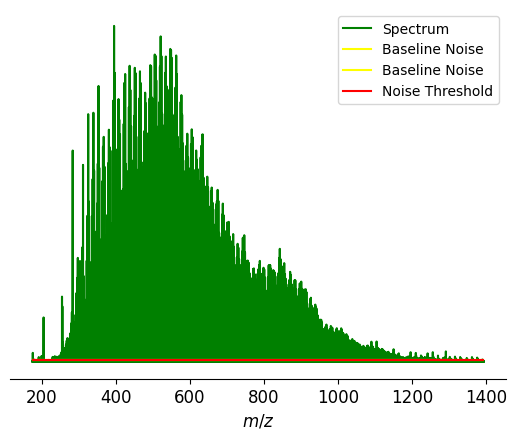

In [ ]:
# Choose noise threshold method and minimum value
MSParameters.mass_spectrum.noise_threshold_method = "signal_noise"
MSParameters.mass_spectrum.noise_threshold_min_s2n = 6

# Set m/z range for peak picking and noise threshold
MSParameters.mass_spectrum.noise_min_mz = 50.0
MSParameters.mass_spectrum.noise_max_mz = 1500.0
MSParameters.mass_spectrum.min_picking_mz = 50.0
MSParameters.mass_spectrum.max_picking_mz = 1500.0

# Specify file path
file_location = filepaths[3]  # 2021May20_SRFA_Sum568_6p3s_1E6_3sigma_101221.pks

mass_list_reader = ReadMassList(file_location)

# Import centroided spectrum
mass_spectrum = mass_list_reader.get_mass_spectrum(
    polarity=-1, auto_process=True, loadSettings=False
)
print(len(mass_spectrum))

# Plot the mass spectrum
mass_spectrum.plot_profile_and_noise_threshold(legend=True)

### 3. Molecular formula search

See [database_initialization.md](/home/corems/docs/user_guide/database_initialization.md) and [molecular_formula_search.md](/home/corems/docs/user_guide/molecular_formula_search.md) for details about the molecular formula database and search process. Both database initialization and molecular formula searching rely establishing the relevant heteroatom space.


Numerous parameters can be set to facilitate the molecular search process, including element number and element ratio constraints, and ppm and isotope abundance error constraints. Many of these constraints are illustrated below.


In [ ]:
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

# Ion Types
mass_spectrum.molecular_search_settings.isProtonated = True
mass_spectrum.molecular_search_settings.isRadical = False
mass_spectrum.molecular_search_settings.isAdduct = False

# Atom constraints
mass_spectrum.molecular_search_settings.usedAtoms["C"] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms["H"] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms["O"] = (1, 25)
mass_spectrum.molecular_search_settings.usedAtoms["N"] = (0, 5)
mass_spectrum.molecular_search_settings.usedAtoms["S"] = (0, 2)

# Mass error constraints
mass_spectrum.molecular_search_settings.error_method = "None"
mass_spectrum.molecular_search_settings.min_ppm_error = -0.3
mass_spectrum.molecular_search_settings.max_ppm_error = 0.3

# DBE constraints
mass_spectrum.molecular_search_settings.min_dbe = 0
mass_spectrum.molecular_search_settings.max_dbe = 50

# H/C ratio constraints
mass_spectrum.molecular_search_settings.min_hc_filter = 0.3
mass_spectrum.molecular_search_settings.max_hc_filter = 3.0

# O/C ratio constraints
mass_spectrum.molecular_search_settings.min_oc_filter = 0
mass_spectrum.molecular_search_settings.max_oc_filter = 1.3

# Isotope abundance constraints
mass_spectrum.molecular_search_settings.min_abun_error = -20
mass_spectrum.molecular_search_settings.max_abun_error = 10


SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()
mass_spectrum.percentile_assigned(report_error=True)

'runworker'  37.94 ms


Loading molecular formula database: 845139it [01:01, 13842.74it/s]
Started molecular formula search for class {"N": 3, "S": 2, "O": 25}, (de)protonated : 100%|██████████| 300/300 [03:00<00:00,  1.66it/s]
Loading molecular formula database: 415608it [00:34, 12041.66it/s]
Started molecular formula search for class {"N": 5, "S": 2, "O": 25}, (de)protonated : 100%|██████████| 150/150 [00:58<00:00,  2.57it/s]


'run_molecular_formula'  336212.73 ms
42497 assigned peaks and 49810 unassigned peaks, total  = 46.04 %, relative abundance = 85.17 %, RMS error (best candidate) (ppm) = 0.112


(42497, 49810, 46.03876195738135, 85.17453271950363, 0.1118675955221345)

### 4. Exporting Molecular Formula Results


In [6]:
# exporting data
base_dir = Path("/home/corems/data")
exports_dir = base_dir / "exports"

# Create output paths for different formats
csv_file = exports_dir / "2021May20_NegESI_SRFA.csv"

# Save in different formats
mass_spectrum.to_csv(str(csv_file))

# get pandas Dataframe
df = mass_spectrum.to_dataframe()
df.head()

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Molecular Formula,C,H,O,N,S,13C,18O,33S,34S
0,168,175.05466,175.05466,175.054672,0.3163,NaN,4586200.0,38.89,-1,-0.070588,...,C6 H12 O2 N2 S1,6.0,12.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN
1,642,176.05649,176.05649,176.056446,0.3099,NaN,6526965.0,38.10,-1,0.249894,...,C6 H11 O5 N1,6.0,11.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
2,648,176.07166,176.07166,176.071702,0.3007,NaN,30670835.0,36.97,-1,-0.239367,...,C10 H11 O2 N1,10.0,11.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
3,649,176.07169,176.07169,176.071702,0.2853,NaN,3389783.0,35.07,-1,-0.068982,...,C10 H11 O2 N1,10.0,11.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
4,653,176.07888,176.07888,176.078913,0.3138,NaN,5330462.0,38.58,-1,-0.186184,...,C4 H11 O3 N5,4.0,11.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN


### 5. Visualizing Results

The tools for exploring and visualizing molecular formula assignment results are primarily contained in `HeteroatomsClassification`, consistent with the use of heteroatom space to define search space.


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

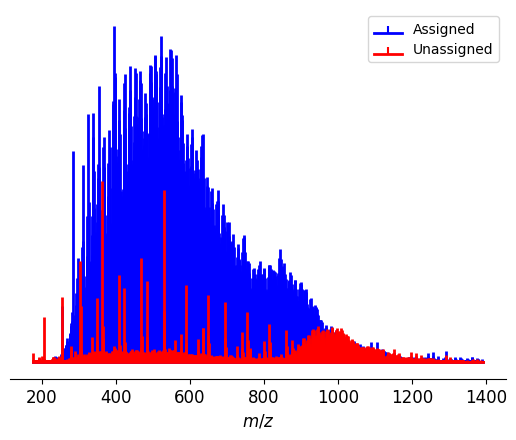

In [7]:
from corems.molecular_id.factory.classification import HeteroatomsClassification

mass_spectrum_by_classes = HeteroatomsClassification(
    mass_spectrum, choose_molecular_formula=True
)
mass_spectrum_by_classes.plot_ms_assigned_unassigned()

<Axes: title={'center': 'Van Krevelen Diagram - All Assigned Classes'}, xlabel='O/C', ylabel='H/C'>

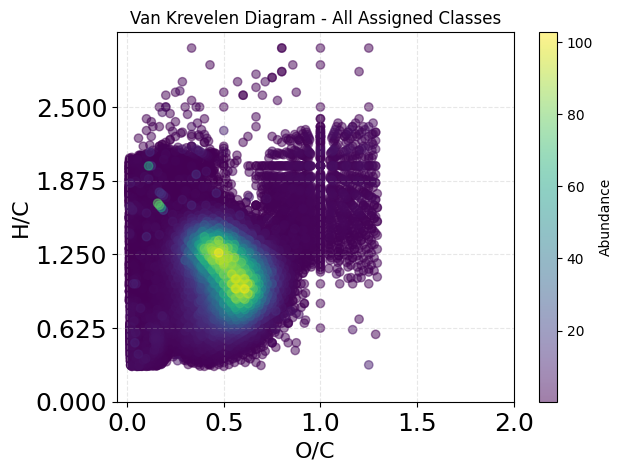

In [8]:
mass_spectrum_by_classes.plot_van_krevelen()

<Axes: title={'center': 'DBE vs Carbon Number - All Assigned Classes'}, xlabel='Carbon number', ylabel='DBE'>

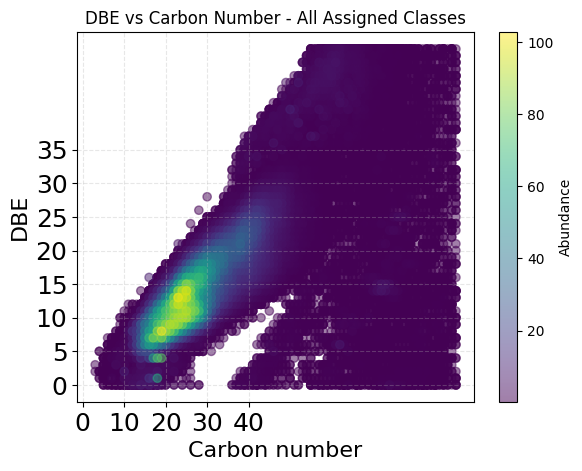

In [9]:
mass_spectrum_by_classes.plot_dbe_vs_carbon_number()

In [10]:
mass_spectrum_by_classes.get_classes()

['O7',
 'O9',
 'O8',
 'O10',
 'O11',
 'O12',
 '13C1 O12',
 'O13',
 '13C1 O13',
 'O14',
 '13C1 O14',
 'O15',
 '13C1 O15',
 'O16',
 'O17',
 'O18',
 'O19',
 'O20',
 'O21',
 'O22',
 'O23',
 'O24']

(<Axes: title={'center': 'O7, 1.56 %'}, xlabel='O/C', ylabel='H/C'>,
 1.558788150305133)

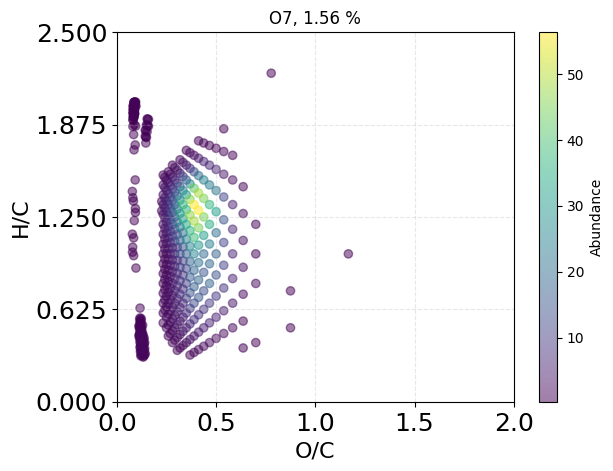

In [11]:
mass_spectrum_by_classes.plot_van_krevelen(classe="O7")

(<Axes: title={'center': 'O7, 1.56 %'}, xlabel='Carbon number', ylabel='DBE'>,
 1.558788150305133)

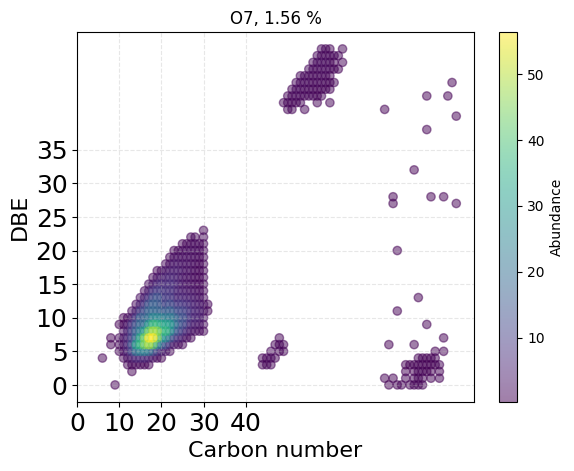

In [15]:
mass_spectrum_by_classes.plot_dbe_vs_carbon_number("O7")

<Axes: title={'center': 'O7, 1.56 %'}, xlabel='$\t{m/z}$', ylabel='Error (ppm)'>

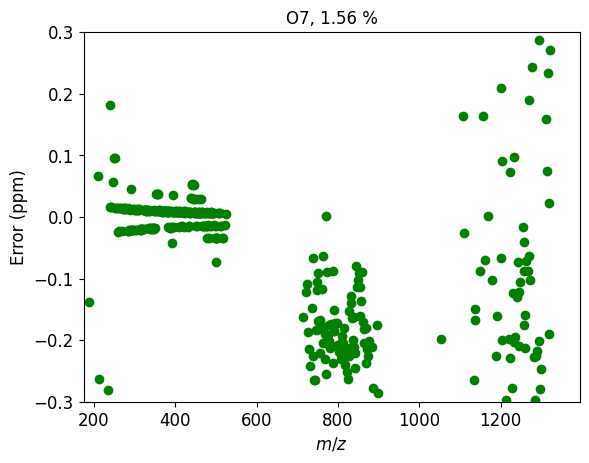

In [12]:
mass_spectrum_by_classes.plot_mz_error_class("O7")

(<Axes: title={'center': 'O15, 3.79 %'}, xlabel='O/C', ylabel='H/C'>,
 3.7869277333613995)

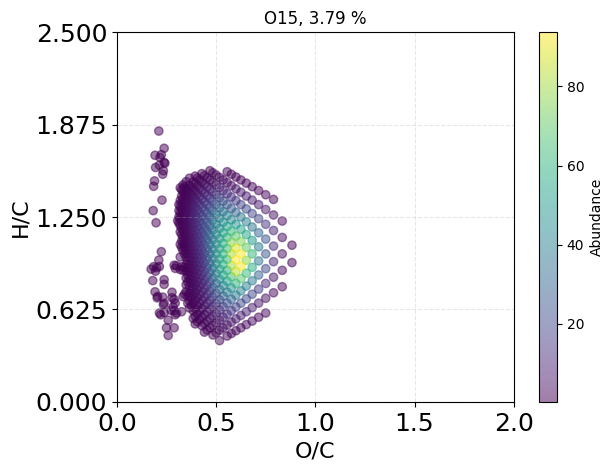

In [13]:
mass_spectrum_by_classes.plot_van_krevelen("O15")

(<Axes: title={'center': 'O15, 3.79 %'}, xlabel='Carbon number', ylabel='DBE'>,
 3.7869277333613995)

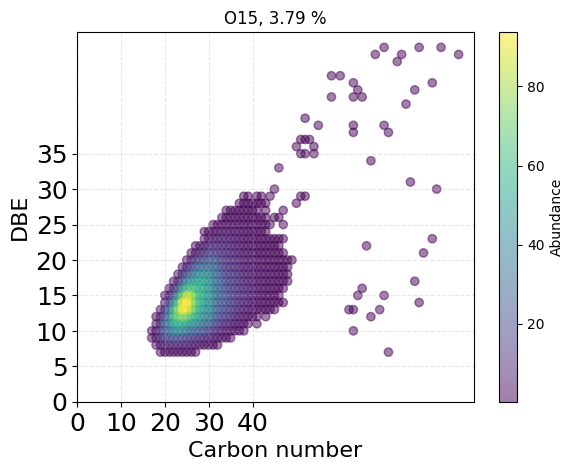

In [16]:
mass_spectrum_by_classes.plot_dbe_vs_carbon_number("O15")

<Axes: title={'center': 'O15, 3.79 %'}, xlabel='$\t{m/z}$', ylabel='Error (ppm)'>

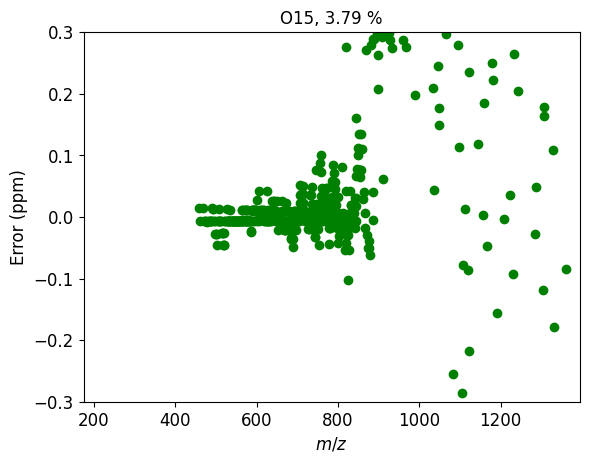

In [14]:
mass_spectrum_by_classes.plot_mz_error_class("O15")